# Audio Fingerprinting and Matching Demo

This Jupyter notebook demonstrates **audio fingerprinting** and **audio matching** for the **RadioPlay** royalty payment system, designed to monitor radio plays for Ghanaian artists. The system identifies songs from 10-second audio clips, similar to Shazam, by generating unique fingerprints and matching them against a database. This demo allows you to:

- Generate fingerprints from audio files (full songs and clips).
- Visualize spectrograms and detected peaks.
- Match clips against a song database.
- Tweak parameters (e.g., `amp_min`, `fan_value`) to optimize matching accuracy.

## Prerequisites

- **Audio Files**: Prepare at least one full song (MP3/WAV) and a 10-second clip (e.g., extracted from the song or recorded with noise). Place them in a `./audio` folder.
- **Dependencies**: Install required Python packages.
- **Environment**: Run this in a Jupyter notebook with access to `ffmpeg` for audio processing.

## Setup

Install dependencies and create an audio folder:

In [13]:
!pip install librosa numba xxhash matplotlib numpy scipy pandas
!mkdir -p ./audio
# Download sample audio (replace with your own files)
# Example: !wget -O ./audio/song1.mp3 <url_to_song>
# Example: !wget -O ./audio/clip1.wav <url_to_clip>

The syntax of the command is incorrect.


## Step 1: Define Fingerprinting Engine

We use a modified fingerprinting engine based on `librosa` for spectrograms, `numba` for fast peak detection, and `xxhash` for hashing. This mirrors the RadioPlay system, which processes 10-second clips from a Flutter app.

**Note**: Modified to pass `peak_neighborhood_size` as a parameter to `get_2D_peaks_numba` to fix `numba` error with global `CONFIG` dictionary access.

In [14]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from numba import jit
import xxhash
from operator import itemgetter
import logging
from typing import List, Tuple

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Configuration (tweak these parameters)
CONFIG = {
    'DEFAULT_FS': 44100,
    'DEFAULT_WINDOW_SIZE': 2048,
    'DEFAULT_OVERLAP_RATIO': 0.5,
    'DEFAULT_FAN_VALUE': 15,
    'DEFAULT_AMP_MIN': 10,
    'PEAK_NEIGHBORHOOD_SIZE': 20,
    'MIN_HASH_TIME_DELTA': 1,
    'MAX_HASH_TIME_DELTA': 200,
    'FINGERPRINT_REDUCTION': 20,
    'PEAK_SORT': True
}

def fingerprint(channel_samples: np.ndarray, Fs: int = CONFIG['DEFAULT_FS'], 
                wsize: int = CONFIG['DEFAULT_WINDOW_SIZE'], wratio: float = CONFIG['DEFAULT_OVERLAP_RATIO'],
                fan_value: int = CONFIG['DEFAULT_FAN_VALUE'], amp_min: float = CONFIG['DEFAULT_AMP_MIN'],
                peak_neighborhood_size: int = CONFIG['PEAK_NEIGHBORHOOD_SIZE']) -> List[Tuple[str, int]]:
    """Generate fingerprints from audio samples.
    
    Args:
        channel_samples: Audio samples (int16).
        Fs: Sampling rate (Hz).
        wsize: FFT window size.
        wratio: Overlap ratio.
        fan_value: Number of peaks to combine per hash.
        amp_min: Minimum amplitude for peaks.
        peak_neighborhood_size: Size of peak detection neighborhood.
    
    Returns:
        List of (hash, offset) tuples.
    """
    try:
        samples = channel_samples.astype(np.float32) / 32768.0  # Normalize to [-1, 1]
        hop_length = int(wsize * (1 - wratio))
        S = librosa.stft(samples, n_fft=wsize, hop_length=hop_length, window='hann')
        arr2D = librosa.amplitude_to_db(np.abs(S), ref=np.max)
        local_maxima = get_2D_peaks(arr2D, amp_min=amp_min, peak_neighborhood_size=peak_neighborhood_size)
        hashes = generate_hashes(local_maxima, fan_value=fan_value)
        logger.info(f"Generated {len(hashes)} fingerprints for {len(samples)/Fs:.2f}s audio")
        return hashes
    except Exception as e:
        logger.error(f"Fingerprinting failed: {e}")
        return []

@jit(nopython=True)
def get_2D_peaks_numba(arr2D: np.ndarray, amp_min: float, peak_neighborhood_size: int) -> List[Tuple[int, int]]:
    """Optimized peak detection with numba.
    
    Args:
        arr2D: Spectrogram matrix.
        amp_min: Minimum amplitude.
        peak_neighborhood_size: Size of peak detection neighborhood.
    
    Returns:
        List of (frequency, time) peak coordinates.
    """
    peaks = []
    rows, cols = arr2D.shape
    neighborhood_size = peak_neighborhood_size // 2
    for i in range(neighborhood_size, rows - neighborhood_size):
        for j in range(neighborhood_size, cols - neighborhood_size):
            if arr2D[i, j] > amp_min:
                is_max = True
                for di in range(-neighborhood_size, neighborhood_size + 1):
                    for dj in range(-neighborhood_size, neighborhood_size + 1):
                        if di == 0 and dj == 0:
                            continue
                        if arr2D[i + di, j + dj] > arr2D[i, j]:
                            is_max = False
                            break
                    if not is_max:
                        break
                if is_max:
                    peaks.append((i, j))
    return peaks

def get_2D_peaks(arr2D: np.ndarray, plot: bool = False, amp_min: float = CONFIG['DEFAULT_AMP_MIN'], 
                 peak_neighborhood_size: int = CONFIG['PEAK_NEIGHBORHOOD_SIZE']) -> List[Tuple[int, int]]:
    """Extract peaks from spectrogram.
    
    Args:
        arr2D: Spectrogram matrix.
        plot: If True, visualize spectrogram and peaks.
        amp_min: Minimum amplitude.
        peak_neighborhood_size: Size of peak detection neighborhood.
    
    Returns:
        List of (frequency, time) peaks.
    """
    try:
        peaks = get_2D_peaks_numba(arr2D, amp_min, peak_neighborhood_size)
        if plot:
            plt.figure(figsize=(10, 6))
            plt.imshow(arr2D, origin='lower', aspect='auto', cmap='viridis')
            if peaks:
                freqs, times = zip(*peaks)
                plt.scatter(times, freqs, c='r', s=10, label='Peaks')
            plt.colorbar(label='Amplitude (dB)')
            plt.xlabel('Time (frames)')
            plt.ylabel('Frequency (bins)')
            plt.title(f'Spectrogram with Detected Peaks (amp_min={amp_min})')
            plt.legend()
            plt.show()
        return peaks
    except Exception as e:
        logger.error(f"Peak detection failed: {e}")
        return []

def generate_hashes(peaks: List[Tuple[int, int]], fan_value: int = CONFIG['DEFAULT_FAN_VALUE']) -> List[Tuple[str, int]]:
    """Generate hashes from peaks.
    
    Args:
        peaks: List of (frequency, time) peaks.
        fan_value: Number of peaks to combine.
    
    Returns:
        List of (hash, offset) tuples.
    """
    try:
        if CONFIG['PEAK_SORT']:
            peaks.sort(key=itemgetter(1))
        hashes = []
        for i in range(len(peaks)):
            for j in range(1, fan_value):
                if (i + j) < len(peaks):
                    freq1 = peaks[i][0]
                    freq2 = peaks[i + j][0]
                    t1 = peaks[i][1]
                    t2 = peaks[i + j][1]
                    t_delta = t2 - t1
                    if CONFIG['MIN_HASH_TIME_DELTA'] <= t_delta <= CONFIG['MAX_HASH_TIME_DELTA']:
                        h = xxhash.xxh64(f"{freq1}|{freq2}|{t_delta}".encode('utf-8'))
                        hash_str = h.hexdigest()[:CONFIG['FINGERPRINT_REDUCTION']]
                        hashes.append((hash_str, t1))
        return hashes
    except Exception as e:
        logger.error(f"Hash generation failed: {e}")
        return []

## Step 2: Load Audio Files

Load a full song and a 10-second clip to simulate radio monitoring. Replace the file paths with your own audio files.

In [15]:
def load_audio(file_path: str) -> Tuple[np.ndarray, int]:
    """Load audio file and convert to int16."""
    try:
        samples, sr = librosa.load(file_path, sr=CONFIG['DEFAULT_FS'], mono=True)
        samples = (samples * 32768).astype(np.int16)
        return samples, sr
    except Exception as e:
        logger.error(f"Failed to load {file_path}: {e}")
        return np.array([]), 0

# Replace with your audio files
song_path = './audio/song1.mp3'  # Full song
clip_path = './audio/clip1.wav'  # 10-second clip

song_samples, song_sr = load_audio(song_path)
clip_samples, clip_sr = load_audio(clip_path)

print(f"Loaded song: {len(song_samples)/song_sr:.2f}s, {song_sr} Hz")
print(f"Loaded clip: {len(clip_samples)/clip_sr:.2f}s, {clip_sr} Hz")

Loaded song: 215.48s, 44100 Hz
Loaded clip: 10.00s, 44100 Hz


## Step 3: Generate Fingerprints for Song

Generate fingerprints for the full song and visualize the spectrogram with peaks. Try tweaking `amp_min` to see how it affects peak detection.

**Note**: Updated to pass `peak_neighborhood_size` to `fingerprint` function.


Generating fingerprints with amp_min=1


INFO:__main__:Generated 0 fingerprints for 215.48s audio
C:\Users\Etornam\AppData\Local\Temp\ipykernel_11696\1068478488.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


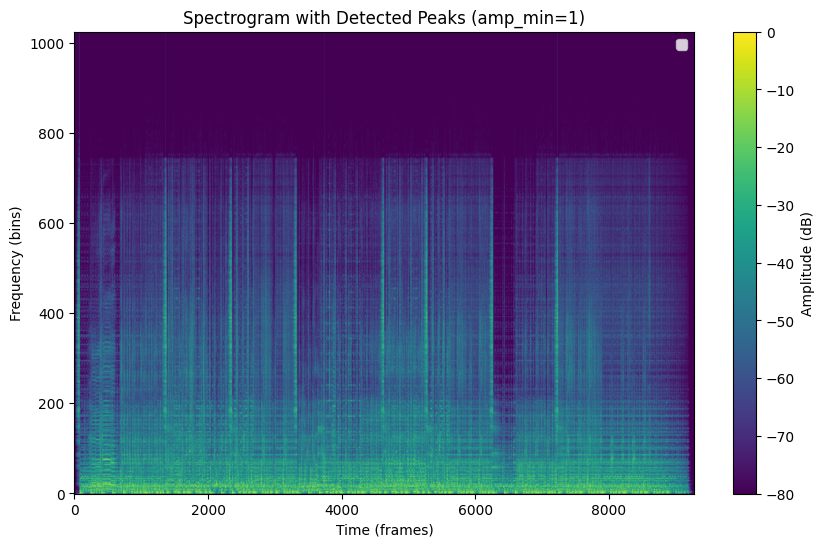

Stored 0 fingerprints

Generating fingerprints with amp_min=3


INFO:__main__:Generated 0 fingerprints for 215.48s audio


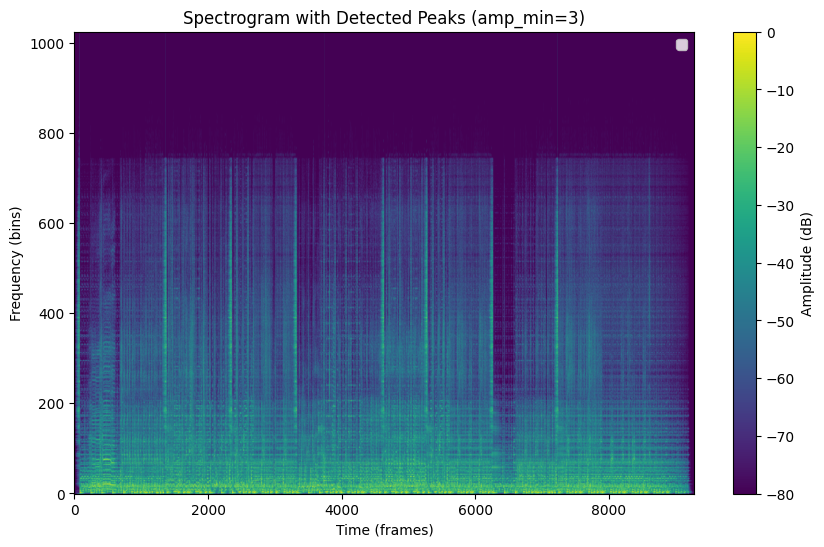

Stored 0 fingerprints

Generating fingerprints with amp_min=5


INFO:__main__:Generated 0 fingerprints for 215.48s audio


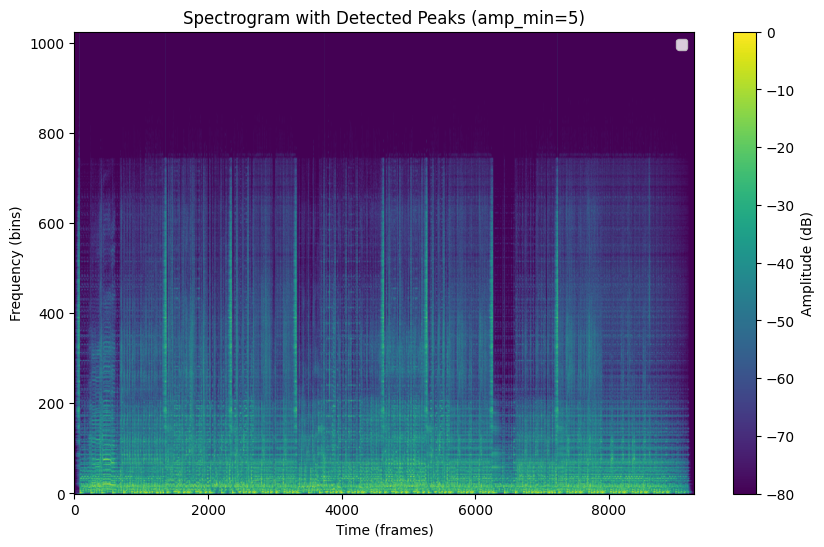

Stored 0 fingerprints


In [16]:
# Simulate Django Song model
class Song:
    def __init__(self, id, title):
        self.id = id
        self.title = title

# Create a song entry
song = Song(id=1, title='Sample Song')

# Generate fingerprints with visualization
def generate_song_fingerprints(samples, sr, song_id, amp_min=CONFIG['DEFAULT_AMP_MIN'], plot=True):
    """Generate fingerprints for a song and store them with song_id.
    
    Args:
        samples: Audio samples.
        sr: Sampling rate.
        song_id: ID of the song.
        amp_min: Minimum amplitude for peak detection.
        plot: If True, display spectrogram with peaks.
    
    Returns:
        List of (song_id, hash, offset) tuples.
    """
    # Compute spectrogram for visualization
    samples_float = samples.astype(np.float32) / 32768.0
    hop_length = int(CONFIG['DEFAULT_WINDOW_SIZE'] * (1 - CONFIG['DEFAULT_OVERLAP_RATIO']))
    S = librosa.stft(samples_float, n_fft=CONFIG['DEFAULT_WINDOW_SIZE'], hop_length=hop_length, window='hann')
    arr2D = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    
    # Generate fingerprints
    fingerprints = fingerprint(samples, Fs=sr, amp_min=amp_min, peak_neighborhood_size=CONFIG['PEAK_NEIGHBORHOOD_SIZE'])
    
    # Store in in-memory database
    db_fingerprints = [(song_id, h, o) for h, o in fingerprints]
    
    # Visualize spectrogram and peaks
    if plot:
        get_2D_peaks(arr2D, plot=True, amp_min=amp_min, peak_neighborhood_size=CONFIG['PEAK_NEIGHBORHOOD_SIZE'])
    
    return db_fingerprints

# Try different amp_min values
amp_min_values = [1, 3, 5]
song_fingerprints = []
for amp_min in amp_min_values:
    print(f"\nGenerating fingerprints with amp_min={amp_min}")
    fingerprints = generate_song_fingerprints(song_samples, song_sr, song.id, amp_min=amp_min, plot=True)
    song_fingerprints.append((amp_min, fingerprints))
    print(f"Stored {len(fingerprints)} fingerprints")

## Step 4: Match Clip Against Song

Generate fingerprints for the clip and match them against the song’s fingerprints. Visualize matching results and tweak parameters.

**Note**: Updated to pass `peak_neighborhood_size` to `fingerprint` function.

In [17]:
from collections import Counter

def match_clip(clip_samples, clip_sr, db_fingerprints, amp_min=CONFIG['DEFAULT_AMP_MIN'], fan_value=CONFIG['DEFAULT_FAN_VALUE']):
    """Match clip fingerprints against database.
    
    Args:
        clip_samples: Audio samples of clip.
        clip_sr: Sampling rate.
        db_fingerprints: List of (song_id, hash, offset) tuples.
        amp_min: Minimum amplitude for clip fingerprints.
        fan_value: Number of peaks to combine.
    
    Returns:
        Dictionary with match results.
    """
    # Generate clip fingerprints
    clip_fingerprints = fingerprint(clip_samples, Fs=clip_sr, amp_min=amp_min, fan_value=fan_value, 
                                    peak_neighborhood_size=CONFIG['PEAK_NEIGHBORHOOD_SIZE'])
    if not clip_fingerprints:
        return {"match": False, "reason": "No fingerprints extracted"}
    
    # Match fingerprints
    query_hashes = [h for h, _ in clip_fingerprints]
    db_hashes = {(h, o, song_id) for song_id, h, o in db_fingerprints if h in query_hashes}
    if not db_hashes:
        return {"match": False, "reason": "No matching hashes found"}
    
    match_map = Counter()
    for h, query_offset in clip_fingerprints:
        for db_hash, db_offset, song_id in db_hashes:
            if h == db_hash:
                offset_diff = db_offset - query_offset
                match_map[(song_id, offset_diff)] += 1
    
    if not match_map:
        return {"match": False, "reason": "No offset alignment found"}
    
    (song_id, offset_diff), match_count = match_map.most_common(1)[0]
    total_query_hashes = len(query_hashes)
    total_db_hashes = sum(1 for _, _, sid in db_fingerprints if sid == song_id)
    input_confidence = (match_count / total_query_hashes) * 100
    db_confidence = (match_count / total_db_hashes) * 100 if total_db_hashes else 0
    
    # Thresholds (tweak these)
    MIN_MATCH_COUNT = 50
    MIN_INPUT_CONF = 20.0
    MIN_DB_CONF = 5.0
    
    if match_count < MIN_MATCH_COUNT or input_confidence < MIN_INPUT_CONF or db_confidence < MIN_DB_CONF:
        return {
            "match": False,
            "reason": "Low confidence match",
            "hashes_matched": match_count,
            "input_confidence": input_confidence,
            "db_confidence": db_confidence
        }
    
    return {
        "match": True,
        "song_id": song_id,
        "offset": offset_diff,
        "hashes_matched": match_count,
        "input_confidence": input_confidence,
        "db_confidence": db_confidence
    }

# Match clip with different parameters
results = []
for amp_min, db_fingerprints in song_fingerprints:
    for fan_value in [10, 15, 20]:
        print(f"\nMatching clip with amp_min={amp_min}, fan_value={fan_value}")
        result = match_clip(clip_samples, clip_sr, db_fingerprints, amp_min=amp_min, fan_value=fan_value)
        results.append({
            'amp_min': amp_min,
            'fan_value': fan_value,
            'result': result
        })
        print(result)


Matching clip with amp_min=1, fan_value=10


INFO:__main__:Generated 0 fingerprints for 10.00s audio


{'match': False, 'reason': 'No fingerprints extracted'}

Matching clip with amp_min=1, fan_value=15


INFO:__main__:Generated 0 fingerprints for 10.00s audio


{'match': False, 'reason': 'No fingerprints extracted'}

Matching clip with amp_min=1, fan_value=20


INFO:__main__:Generated 0 fingerprints for 10.00s audio


{'match': False, 'reason': 'No fingerprints extracted'}

Matching clip with amp_min=3, fan_value=10


INFO:__main__:Generated 0 fingerprints for 10.00s audio


{'match': False, 'reason': 'No fingerprints extracted'}

Matching clip with amp_min=3, fan_value=15


INFO:__main__:Generated 0 fingerprints for 10.00s audio


{'match': False, 'reason': 'No fingerprints extracted'}

Matching clip with amp_min=3, fan_value=20


INFO:__main__:Generated 0 fingerprints for 10.00s audio


{'match': False, 'reason': 'No fingerprints extracted'}

Matching clip with amp_min=5, fan_value=10


INFO:__main__:Generated 0 fingerprints for 10.00s audio


{'match': False, 'reason': 'No fingerprints extracted'}

Matching clip with amp_min=5, fan_value=15


INFO:__main__:Generated 0 fingerprints for 10.00s audio


{'match': False, 'reason': 'No fingerprints extracted'}

Matching clip with amp_min=5, fan_value=20


INFO:__main__:Generated 0 fingerprints for 10.00s audio


{'match': False, 'reason': 'No fingerprints extracted'}


## Step 5: Visualize Matching Results

Plot match confidence for different parameter combinations to guide tweaking.

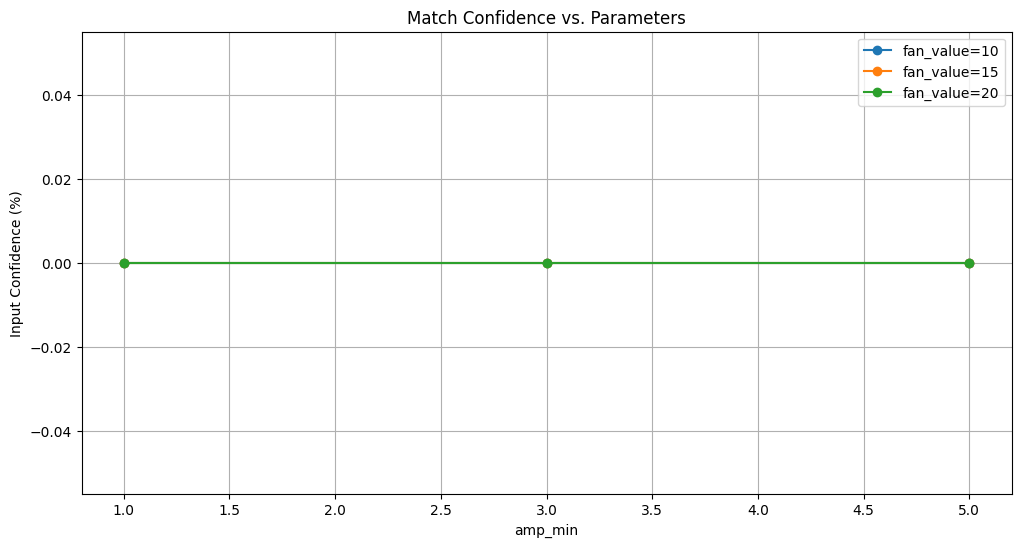


Matching Results Summary:
   amp_min  fan_value  match  input_confidence  db_confidence  hashes_matched
0        1         10  False                 0              0               0
1        1         15  False                 0              0               0
2        1         20  False                 0              0               0
3        3         10  False                 0              0               0
4        3         15  False                 0              0               0
5        3         20  False                 0              0               0
6        5         10  False                 0              0               0
7        5         15  False                 0              0               0
8        5         20  False                 0              0               0


In [18]:
import pandas as pd

# Create DataFrame from results
data = []
for r in results:
    row = {
        'amp_min': r['amp_min'],
        'fan_value': r['fan_value'],
        'match': r['result']['match'],
        'input_confidence': r['result'].get('input_confidence', 0),
        'db_confidence': r['result'].get('db_confidence', 0),
        'hashes_matched': r['result'].get('hashes_matched', 0)
    }
    data.append(row)

df = pd.DataFrame(data)

# Plot confidence
plt.figure(figsize=(12, 6))
for fan_value in df['fan_value'].unique():
    subset = df[df['fan_value'] == fan_value]
    plt.plot(subset['amp_min'], subset['input_confidence'], marker='o', label=f'fan_value={fan_value}')
plt.xlabel('amp_min')
plt.ylabel('Input Confidence (%)')
plt.title('Match Confidence vs. Parameters')
plt.legend()
plt.grid(True)
plt.show()

# Display results table
print("\nMatching Results Summary:")
print(df)

## Step 6: Tweak Parameters

Based on the plots and table, adjust parameters:
- **amp_min**: Lower values detect more peaks but increase noise. Higher values are stricter but may miss peaks.
- **fan_value**: Higher values create more fingerprints but increase storage and processing time.
- **MIN_MATCH_COUNT**, **MIN_INPUT_CONF**, **MIN_DB_CONF**: Tune thresholds to balance sensitivity and specificity.

Try modifying `CONFIG` and re-running steps 3–5. For example:
- Set `CONFIG['DEFAULT_AMP_MIN'] = 8` for noisy clips.
- Set `CONFIG['DEFAULT_FAN_VALUE'] = 12` for faster processing.

## Integration with RadioPlay

To use this in your Django system:
1. Save fingerprints to your `Fingerprint` model:
   ```python
   for song_id, h, o in db_fingerprints:
       Fingerprint.objects.create(song_id=song_id, hash=h, offset=o)
   ```
2. Adapt `match_clip` to query your database:
   ```python
   db_fps = Fingerprint.objects.filter(hash__in=query_hashes)
   ```
3. Use these visualizations to tune parameters in your `settings.py`.

## Next Steps

- Test with more songs and noisy clips to simulate real radio broadcasts.
- Experiment with other parameters (e.g., `wsize`, `wratio`).
- Integrate with your Flutter app to process real-time clips.